# Scratch work

## Imports

In [54]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

from scipy.stats import mode

## Loading data <a id="steps"></a>

For this project we'll be working with data on all commercial flights in January 2019. The data comes from a [Kaggle dataset](https://www.kaggle.com/divyansh22/flight-delay-prediction).

In [5]:
df = pd.read_csv('../data/flights_jan_2019.csv')

In [6]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


## Data preparation

We'll start by only selecting the columns we want. Some columns are reduncant, as they give the airport both as a number and as an abbreviation. Some are not especially useful, like the tail number on the airplane. You can see a description of each column at the link to the dataset above. We have a description of the columns we are keeping below.

In [7]:
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [8]:
cols = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'DISTANCE']
df = df[cols]

Let's make the column names lowercase and do our usual check of missing values. We'll also rename the `op_carrier_airline_id` column to something simpler.

In [9]:
cleaned_cols = [c.lower() if c != 'OP_CARRIER_AIRLINE_ID' else 'airline' for c in df.columns]
df.columns = cleaned_cols

for col in df.columns:
    missing_value_count = df[col].isna().sum()
    missing_value_pct = missing_value_count / df.shape[0]
    print(f'{col}: {missing_value_count} missing ({100*missing_value_pct:.2f}%)')

day_of_month: 0 missing (0.00%)
day_of_week: 0 missing (0.00%)
airline: 0 missing (0.00%)
origin: 0 missing (0.00%)
dest: 0 missing (0.00%)
dep_time: 16352 missing (2.80%)
dep_del15: 16355 missing (2.80%)
arr_time: 17061 missing (2.92%)
arr_del15: 18022 missing (3.09%)
cancelled: 0 missing (0.00%)
diverted: 0 missing (0.00%)
distance: 0 missing (0.00%)


Here is a brief description of the columns we are keeping (or at least the ones which aren't self-explanatory):
- **airline:** A unique identifier for the airline
- **origin:** The airport the plane started at
- **dest:** The airport the plane was headed to
- **dep_time:** The actual departure time, in the format "hhmm"
- **dep_del15:** Whether or not the flight departure was delayed by 15 minutes or more (0 = not delayed, 1 = delayed)
- **arr_time:** The actual arrival time, in the format "hhmm"
- **arr_del15:** Whether or not the flight arrival was delayed by 15 minutes or more
- **cancelled:** Whether or not the flight was cancelled (0 = not cancelled, 1 = cancelled)
- **diverted:** Whether or not the flight was diverted (told to change path, 0 = No, 1 = Yes)
- **distance:** The distance between the airports in miles

In this notebook we are interested in predicting whether or not a flight will be delayed upon arrival (will it arrive later than scheduled). Therefore, we will drop any rows which have missing values are the departure and arrival times/delays.

In [10]:
df = df.dropna(how='any')

In [11]:
print(f'{df.shape[0]} rows remaining')

565963 rows remaining


Let's check each column to make sure the data is what we expect it to be.

In [12]:
df.dtypes

day_of_month      int64
day_of_week       int64
airline           int64
origin           object
dest             object
dep_time        float64
dep_del15       float64
arr_time        float64
arr_del15       float64
cancelled       float64
diverted        float64
distance        float64
dtype: object

These look good, except that the time columns (`dep_time` and `arr_time`) are of the form "hhmm", and we'd really like this to be simpler to work with. Let's just convert it to hours, so that "1200" becomes 12, and "1430" because 14.5 (since 30 minutes = 0.5 hours). Right now these are all stored as floats, which means getting the first two and last two digits is a bit tricky. What would be simpler is just to tell Pandas when loading this data that we want those columns to be strings. You can do this when running `read_csv()` by setting `dtype={'col_name': col_type}`. Rather than going through all this work again, we'll also tell Pandas to only load the subset of columns we want, using the `usecols=[first_col_number, second_col_number, ...]` parameter. You tell it which number column you want (they start at zero). Finally, we can specify `names=['col1_new_name', 'col2_new_name', ...]` to tell it what names we want to use.

In [13]:
# Note that cols is the list of columns we want, which we defined earlier. cleaned_cols is the cleaned up column names we did earlier as well.
df = pd.read_csv('../data/flights_jan_2019.csv', 
                 usecols=cols,
                 dtype={'DEP_TIME': str, 'ARR_TIME': str})

df.columns = cleaned_cols

df = df.dropna(how='any')

In [14]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_time,dep_del15,arr_time,arr_del15,cancelled,diverted,distance
0,1,2,20363,GNV,ATL,0601,0.0,0722,0.0,0.0,0.0,300.0
1,1,2,20363,MSP,CVG,1359,0.0,1633,0.0,0.0,0.0,596.0
2,1,2,20363,DTW,CVG,1215,0.0,1329,0.0,0.0,0.0,229.0
3,1,2,20363,TLH,ATL,1521,0.0,1625,0.0,0.0,0.0,223.0
4,1,2,20363,ATL,FSM,1847,0.0,1940,0.0,0.0,0.0,579.0


That looks better. Let's now create the departure and arrival hour columns as described earlier. 

In [15]:
def hhmm_to_hour(hhmm):
    # Get the first two characters
    hh = hhmm[:2]
    # Get the last two characters
    mm = hhmm[2:]
    # Turn them into integeres
    hh = int(hh)
    mm = int(mm)
    # Math
    hour = hh + mm/60
    return hour

In [16]:
# Testing it out
hhmm_to_hour('1430')

14.5

In [17]:
df['dep_hour'] = df['dep_time'].apply(hhmm_to_hour)
df['arr_hour'] = df['arr_time'].apply(hhmm_to_hour)

In [18]:
df = df.drop(['dep_time', 'arr_time'], axis='columns')

In [19]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
0,1,2,20363,GNV,ATL,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667
1,1,2,20363,MSP,CVG,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000
2,1,2,20363,DTW,CVG,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333
3,1,2,20363,TLH,ATL,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667
4,1,2,20363,ATL,FSM,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667


In [20]:
origin_le = LabelEncoder()
df['origin'] = origin_le.fit_transform(df['origin'])

dest_le = LabelEncoder()
df['dest'] = dest_le.fit_transform(df['dest'])

In [21]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
0,1,2,20363,128,19,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667
1,1,2,20363,225,80,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000
2,1,2,20363,95,80,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333
3,1,2,20363,325,19,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667
4,1,2,20363,19,120,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667


## Data exploration

Since the goal is to understand flight delays, let's start by looking at the flights that are delayed. First, how many of them are there?

In [22]:
df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

We only care about those that are delayed upon arrival, but let's also check out the departures.

In [23]:
df['dep_del15'].value_counts(normalize=True)

0.0    0.826305
1.0    0.173695
Name: dep_del15, dtype: float64

Almost identical. How many flights have a delayed arrival but *not* a delayed departure (or vice-versa)?

In [24]:
dep_del15_df = df[df['dep_del15'] == 1]
dep_del15_df['arr_del15'].value_counts(normalize=True)

1.0    0.796379
0.0    0.203621
Name: arr_del15, dtype: float64

So of those flights with a delayed departure, almost 80% of them also have a delayed arrival. Let's now do vice-versa.

In [25]:
arr_del15_df = df[df['arr_del15'] == 1]
arr_del15_df['dep_del15'].value_counts(normalize=True)

1.0    0.744027
0.0    0.255973
Name: dep_del15, dtype: float64

Of those with a delayed arrival, about 74% of them had a delayed departure. So (not surprisingly) when predicting whether or not the arrival will be delayed, looking at whether or not the departure is delayed is highly relevant.

Next, we see that about 18.6% of flights have a delayed arrival. Let's go through each day of the month and see if one tends to have a much higher or lower rate than that. We'll do this using `groupby`. We'll add up the delayed arrivals for each day of the month using `.sum()`. Since `arr_del15` is either 0 or 1, adding it up will count how many delays there are. To get this as a percentage we'll divide by the `.count()` of how many flights arrived on that day of the month.

In [26]:
df.groupby('day_of_month')['arr_del15'].sum() / df.groupby('day_of_month')['arr_del15'].count()

day_of_month
1     0.215423
2     0.257957
3     0.186185
4     0.127087
5     0.160788
6     0.198471
7     0.151579
8     0.101620
9     0.103387
10    0.143248
11    0.160589
12    0.150572
13    0.162158
14    0.151467
15    0.154934
16    0.129132
17    0.200223
18    0.219003
19    0.201091
20    0.210049
21    0.269010
22    0.225870
23    0.272890
24    0.311952
25    0.226672
26    0.133417
27    0.188134
28    0.178465
29    0.145864
30    0.204032
31    0.208535
Name: arr_del15, dtype: float64

It looks like there are a few days of the month with especially high/low delays, such as days 8 and 9 with only 10%, and day 24 with 31%. So maybe this column will be useful for our model. Let's do the same for `day_of_week`, `airline`, `origin` and `dest`.

In [27]:
groupby_cols = ['day_of_week', 'airline', 'origin', 'dest']

for c in groupby_cols:
    print(df.groupby(c)['arr_del15'].sum() / df.groupby(c)['arr_del15'].count())
    print('='*40)

day_of_week
1    0.186837
2    0.167916
3    0.193716
4    0.209893
5    0.183462
6    0.160310
7    0.189246
Name: arr_del15, dtype: float64
airline
19393    0.150240
19690    0.125424
19790    0.128101
19805    0.182353
19930    0.173530
19977    0.198500
20304    0.227036
20363    0.202462
20366    0.247705
20368    0.258142
20378    0.185653
20397    0.155349
20398    0.246478
20409    0.274802
20416    0.158771
20436    0.248894
20452    0.238675
Name: arr_del15, dtype: float64
origin
0      0.202492
1      0.190476
2      0.128326
3      0.133333
4      0.084337
         ...   
341    0.131148
342    0.214286
343    0.200593
344    0.160000
345    0.078261
Name: arr_del15, Length: 346, dtype: float64
dest
0      0.197531
1      0.142857
2      0.144028
3      0.150000
4      0.120482
         ...   
341    0.171488
342    0.222222
343    0.176355
344    0.264151
345    0.139130
Name: arr_del15, Length: 346, dtype: float64


## Resampling

In [86]:
y_col = 'arr_del15'

X_cont_cols = ['day_of_month', 'distance', 'dep_hour', 'arr_hour']
X_cat_cols = ['day_of_week', 'airline', 'origin', 'dest', 'cancelled', 'diverted', 'dep_del15']
X_all_cols = X_cont_cols + X_cat_cols

X_train_cont = train_df[X_cont_cols]
X_train_cat = train_df[X_cat_cols]
X_train_all = train_df[X_all_cols]

X_test_cont = test_df[X_cont_cols]
X_test_cat = test_df[X_cat_cols]
X_test_all = test_df[X_all_cols]

y_train = train_df[y_col]
y_test = test_df[y_col]

In [87]:
train_df['arr_del15'].value_counts()

0.0    276444
1.0     63133
Name: arr_del15, dtype: int64

### Undersampling

In [88]:
# Minority class has 63,133 samples
n_samples = 63133

train_delayed_df = train_df[train_df['arr_del15'] == 1]
train_not_delayed_df = train_df[train_df['arr_del15'] == 0].sample(n_samples)

train_under_df = pd.concat([train_delayed_df, train_not_delayed_df])

X_train_under = train_under_df[X_all_cols]
y_train_under = train_under_df[y_col]

### Oversampling

In [89]:
# Majority class has 63,133 samples
n_samples = 276444

train_delayed_df = train_df[train_df['arr_del15'] == 0]
train_not_delayed_df = train_df[train_df['arr_del15'] == 1].sample(n_samples, replace=True)

train_over_df = pd.concat([train_delayed_df, train_not_delayed_df])

X_train_over = train_over_df[X_all_cols]
y_train_over = train_over_df[y_col]

## Model building

In [90]:
train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['arr_del15'])

In [91]:
train_df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

In [92]:
test_df['arr_del15'].value_counts(normalize=True)

0.0    0.814083
1.0    0.185917
Name: arr_del15, dtype: float64

## Model building

### DT on all data

In [77]:
hyperparam_grid = {'min_samples_split': [5, 25, 50, 100, 150, 200, 250, 300],
                  'max_depth': [5, 25, 50, 100, 150, 200, 250, 300],
                  'min_samples_leaf': [5, 25, 50, 100, 150, 200, 250, 300]}

In [78]:
dt_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_clf, hyperparam_grid, n_jobs=-1) # n_jobs tells it to use parallel processing. Long story short, it will be faster.

In [79]:
# This may take a while, go grab a coffee...
grid_search.fit(X_train_all, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 25, 50, 100, 150, 200, 250, 300],
 

In [93]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5}

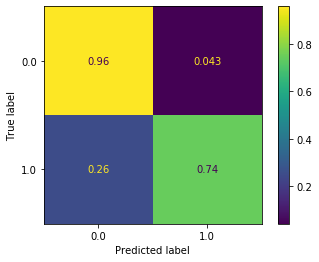

In [94]:
plot_confusion_matrix(grid_search, X_test_all, y_test, normalize='true')

### DT on undersampled data

In [95]:
dt_clf_under = DecisionTreeClassifier()

grid_search_under = GridSearchCV(dt_clf_under, hyperparam_grid, n_jobs=-1)

In [96]:
grid_search_under.fit(X_train_under, y_train_under)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 25, 50, 100, 150, 200, 250, 300],
 

In [97]:
grid_search_under.best_params_

{'max_depth': 25, 'min_samples_leaf': 100, 'min_samples_split': 250}

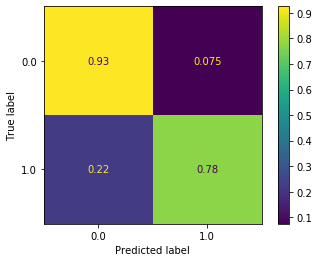

In [98]:
plot_confusion_matrix(grid_search_under, X_test_all, y_test, normalize='true')

### DT on oversampled data

{'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5}


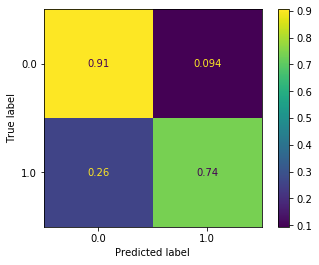

In [99]:
dt_clf_over = DecisionTreeClassifier()

grid_search_over = GridSearchCV(dt_clf_over, hyperparam_grid, n_jobs=-1)

grid_search_over.fit(X_train_over, y_train_over)

print(grid_search_over.best_params_)

plot_confusion_matrix(grid_search_over, X_test_all, y_test, normalize='true')

## Feature engineering

In [100]:
def bucketize(df, col, n_buckets=4):
    bucket_col_name = f'{col}_bucket'
    df[bucket_col_name] = pd.cut(df[col], n_buckets)
    buck_le = LabelEncoder()
    df[bucket_col_name] = buck_le.fit_transform(df[bucket_col_name])

In [101]:
cols_to_bucketize = ['distance', 'dep_hour', 'arr_hour']

for c in cols_to_bucketize:
    bucketize(df, c)
    bucketize(train_df, c)
    bucketize(test_df, c)

<ipython-input-100-d55f4f170f27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bucket_col_name] = pd.cut(df[col], n_buckets)
<ipython-input-100-d55f4f170f27>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bucket_col_name] = buck_le.fit_transform(df[bucket_col_name])


In [102]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour,distance_bucket,dep_hour_bucket,arr_hour_bucket
0,1,2,20363,128,19,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667,0,1,1
1,1,2,20363,225,80,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000,0,2,2
2,1,2,20363,95,80,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333,0,2,2
3,1,2,20363,325,19,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667,0,2,2
4,1,2,20363,19,120,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667,0,3,3


In [103]:
X_bucket_cols = ['day_of_month', 'day_of_week', 'airline', 'origin', 'dest', 'dep_del15', 'cancelled', 'diverted', 'distance_bucket', 'dep_hour_bucket', 'arr_hour_bucket']

X_train_bucket = train_df[X_bucket_cols]
X_test_bucket = test_df[X_bucket_cols]

### DT with bucketize columns (original data, not resampled)

{'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 100}


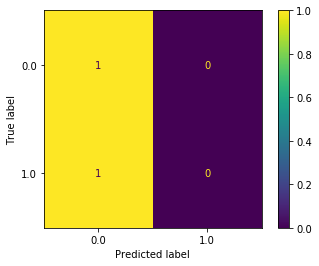

In [104]:
dt_clf_bucket = DecisionTreeClassifier()

grid_search_bucket = GridSearchCV(dt_clf_bucket, hyperparam_grid, n_jobs=-1)

grid_search_bucket.fit(X_train_bucket, y_train)

print(grid_search_bucket.best_params_)

plot_confusion_matrix(grid_search_bucket, X_test_all, y_test, normalize='true')

In [105]:
X_train_bucket.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,cancelled,diverted,distance_bucket,dep_hour_bucket,arr_hour_bucket
61306,4,5,20378,159,89,0.0,0.0,0.0,0,2,2
298373,16,3,20409,39,41,1.0,0.0,0.0,0,3,0
532312,29,2,19977,109,21,0.0,0.0,0.0,1,1,2
33646,2,3,20398,280,238,1.0,0.0,0.0,0,3,3
53779,3,4,20452,68,87,0.0,0.0,0.0,0,3,3


In [111]:
np.unique(grid_search_bucket.predict(X_test_all), return_counts=True)

(array([0.]), array([226386]))